In [1]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy import signal
import matplotlib.pyplot as plt
import cvxpy as cp

# Thruster lumped-mass model
![*Lumped Mass Model*](lumped_thruster.png)

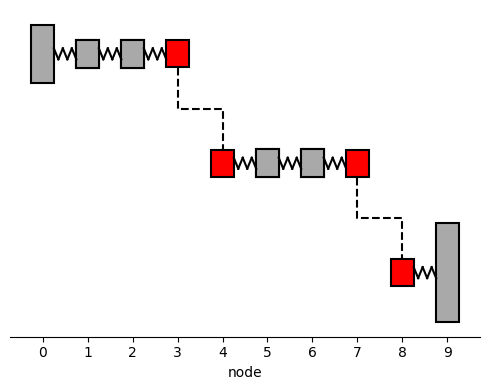

In [74]:
import opentorsion as ot

#Mass moment of inertia
inertia = [300, 3.08, 8.83, 5.03/2, 5.03/2, 3.74, 4.46, 9.72/2, 9.72/2, 693.50]
# Damping (Nm/(rad/s))
damping = [1000, 1943, 970, 798, 1399, 469, 4570]
# Stiffness Nm/rad
stiffness = [1000E4, 2151E4, 1074E4, 884E4, 126200E4, 519E4, 5060E4]
# relative friction damping
friction_damping = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Syntax is: ot.Shaft(node 1, node 2, Length [mm], outer diameter [mm], stiffness [Nm/rad], damping)
shafts = [
    ot.Shaft(0, 1, L=None, odl=None, k=damping[0], c=stiffness[0]),
    ot.Shaft(1, 2, L=None, odl=None, k=damping[1], c=stiffness[1]),
    ot.Shaft(2, 3, L=None, odl=None, k=damping[2], c=stiffness[2]),
    ot.Shaft(4, 5, L=None, odl=None, k=damping[3], c=stiffness[3]),
    ot.Shaft(5, 6, L=None, odl=None, k=damping[4], c=stiffness[4]),
    ot.Shaft(6, 7, L=None, odl=None, k=damping[5], c=stiffness[5]),
    ot.Shaft(8, 9, L=None, odl=None, k=damping[5], c=stiffness[5]),
]
# Syntax is: ot.Disk(node, Inertia [kgm^2], damping)
disks=[]           
for i in range(len(inertia)):
    disks.append( ot.Disk(i, I=inertia[i], c=friction_damping[i]) )

# Syntax is: ot.Gear(node, Inertia [kgm^2], radius/teeth, parent)
gear31 = ot.Gear(3, 0, 21)
gear32 = ot.Gear(4, 0, 29, parent=gear31)
                 
gear61 = ot.Gear(7, 0, 14)
gear62 = ot.Gear(8, 0, 23, parent=gear61)

gears = [gear31, gear32, gear61, gear62]

drivetrain = ot.Assembly(shafts, disks, gear_elements=gears)

# plot drivetrain
plot_tools = ot.Plots(drivetrain)
plot_tools.plot_assembly()

# get discrete-time state space
Ac, Bc = drivetrain.state_space()
Bc = np.column_stack((Bc[:,0], -Bc[:,-1]))
dt = 1/1000
A, B = drivetrain.continuous_2_discrete(Ac, Bc, ts=dt)

# create sensor 
# y(k) = Cx(k), measure angular velocity at disk 1&2, and torque between disks 1&2
C = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0,                           0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0,                           0, 0, 1, 0, 0, 0, 0, 0],
    [0, stiffness[0], -stiffness[0], 0, 0, 0, 0, 0,    0, 0, 0, 0, 0, 0, 0, 0]
])


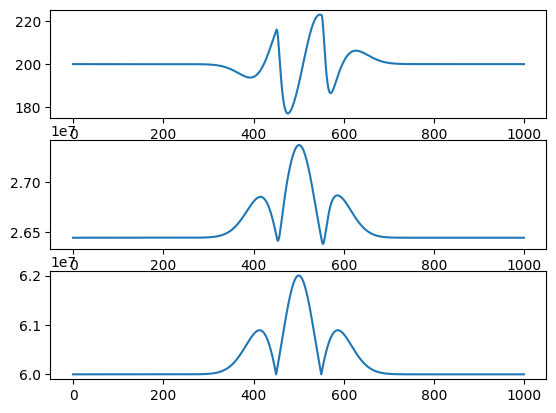

In [84]:
def mexican_hat_wavelet(signal_length, center, width):
    # Create an array of sample indices
    x = np.arange(signal_length)
    
    # Define sigma (standard deviation) of the Gaussian function
    sigma = width / 6  # A common choice for sigma is width/6 to match the width approximately
    
    # Compute the Mexican Hat wavelet
    t = (x - center) / sigma
    wavelet = (1 - t**2) * np.exp(-0.5 * t**2)
    return wavelet

n_states = np.shape(A)[0]
n_inputs = np.shape(B)[1]
n_outputs = np.shape(C)[0]

################################################
BATCH_SIZE = 1200 # batch size
K_PI = 1E5 # PI controller proportional gain
I_PI = 1e4 # PI controller integral gain
################################################

### initialize signals ###
# inputs
u = np.zeros((2, BATCH_SIZE))
excitation = np.abs( mexican_hat_wavelet(BATCH_SIZE, int(BATCH_SIZE/2), int(BATCH_SIZE/4)) )
u[1,:] = 60E6 + 2E6*excitation

#state and measurements
x = np.zeros((n_states, BATCH_SIZE))
y = np.zeros((n_outputs, BATCH_SIZE))
y0 = np.zeros((n_outputs, BATCH_SIZE))

setpoint_velocity = 200/60*2*np.pi #200 RPM -> rad/s


err = 0
err_integrated = 0
for k in range(BATCH_SIZE-1):
    ### PI controller ###
    err = setpoint_velocity - y[0,k-1]
    err_integrated += err
    u[0,k] = 26.4E6 + K_PI*err + I_PI*err_integrated

    #### simulate ###
    x[:,k+1] = A @ x[:,k] + B @ u[:,k]
    y[:,k] = C @ x[:,k]
y[:,k+1] = C @ x[:,k+1]

fig, axs = plt.subplots(3)
axs[0].plot(y[0,100:-100]*60/2/np.pi)
axs[1].plot(u[0,100:-100])
axs[2].plot(u[1,100:-100])

